In [1]:
import os
import shutil
import sh
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import csv data
path = "file:///home/kadochnikov/data/air_travel/"
filename = "200*.csv"
csv_file = path+filename

In [3]:
# Store the csv data as a dataframe in spark
travel_df= sqlContext.read.format('com.databricks.spark.csv').\
options(header='true', inferschema='true', delimiter=',', quote='"').\
load(csv_file).cache()

In [4]:
# Print out the column names
travel_df.first()

Row(Year=2007, Month=1, DayofMonth=1, DayOfWeek=1, DepTime=u'1232', CRSDepTime=1225, ArrTime=u'1341', CRSArrTime=1340, UniqueCarrier=u'WN', FlightNum=2891, TailNum=u'N351', ActualElapsedTime=u'69', CRSElapsedTime=u'75', AirTime=u'54', ArrDelay=u'1', DepDelay=u'7', Origin=u'SMF', Dest=u'ONT', Distance=389, TaxiIn=u'4', TaxiOut=u'11', Cancelled=0, CancellationCode=None, Diverted=0, CarrierDelay=u'0', WeatherDelay=u'0', NASDelay=u'0', SecurityDelay=u'0', LateAircraftDelay=u'0')

In [25]:
travel_df.createOrReplaceTempView("travel")

In [26]:
# Calculate the percentage of delayed flights (arrival) per Origin/Destination pair
arrivals_delays_pct = sqlContext.sql("\
    select a.Origin, a.Dest, a.Num_Total_flights, b.Num_Delayed_Flights, \
    round(b.Num_Delayed_Flights/a.Num_Total_Flights*100,1) as Delayed_Pct \
    from \
    (select Origin, Dest, count(*) as Num_Total_Flights \
    from travel \
    group by Origin, Dest \
    order by Num_Total_Flights desc) a \
    JOIN \
    (select Origin, Dest, count(*) as Num_Delayed_Flights \
    from (select * from travel where ArrDelay>0) \
    group by Origin, Dest \
    order by Num_Delayed_Flights desc) b \
    ON a.Origin = b.Origin and a.Dest = b.Dest")

In [36]:
# Order them by the delayed percentage (highest first)
arrivals_delays_pct_worst = arrivals_delays_pct.orderBy("Delayed_Pct", \
ascending=False)

In [49]:
# Display the results
arrivals_delays_pct_worst.show(5)

+------+----+-----------------+-------------------+-----------+
|Origin|Dest|Num_Total_flights|Num_Delayed_Flights|Delayed_Pct|
+------+----+-----------------+-------------------+-----------+
|   DSM| OMA|                1|                  1|      100.0|
|   RIC| RDU|                2|                  2|      100.0|
|   GSP| CLT|                1|                  1|      100.0|
|   ABE| JFK|                6|                  6|      100.0|
|   OMA| DSM|                1|                  1|      100.0|
+------+----+-----------------+-------------------+-----------+
only showing top 5 rows



In [37]:
# Convert to a pandas dataframe
Arr_Delay_Pct_W = arrivals_delays_pct_worst.toPandas()

In [57]:
# Create a new column that contains both the names of the Origin and Destination
Arr_Delay_Pct_W['Pair'] = Arr_Delay_Pct_W["Origin"].map(str) + \
Arr_Delay_Pct_W["Dest"]

In [72]:
# Filter out the airport pairs with less than 10 total flights
ArrDelayPerWorstFiltered =Arr_Delay_Pct_W[Arr_Delay_Pct_W['Num_Total_flights']>10]
# Display results
ArrDelayPerWorstFiltered.head(5)

,Origin,Dest,Num_Total_flights,Num_Delayed_Flights,Delayed_Pct,Pair
87,LGA,MLB,12,12,100.0,LGAMLB
192,SLC,GUC,14,13,92.9,SLCGUC
193,MKG,GRR,24,22,91.7,MKGGRR
194,ABE,LGA,12,11,91.7,ABELGA
196,DTW,STT,33,29,87.9,DTWSTT


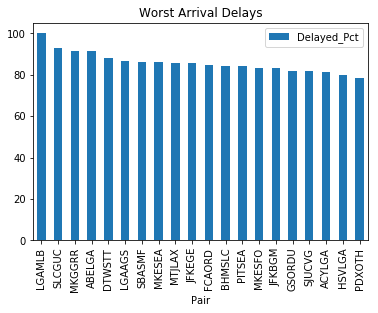

In [58]:
# Plot the first 20 pairs
ArrDelayPerWorstFiltered[:20].plot('Pair', 'Delayed_Pct', kind='bar')
plt.title('Worst Arrival Delays Filtered')
plt.show()

In [59]:
# Reorder the data with the lowest percentage first
arrivals_delays_pct_fewest = \
arrivals_delays_pct.orderBy("Delayed_Pct", ascending=True)

In [32]:
# Convert this to a pandas dataframe
Arr_Delay_Pct = arrivals_delays_pct_fewest.toPandas()

In [33]:
# Add column that contains the name of the Origin/Destination pair
Arr_Delay_Pct['Pair'] = Arr_Delay_Pct["Origin"].map(str) + \
Arr_Delay_Pct["Dest"]

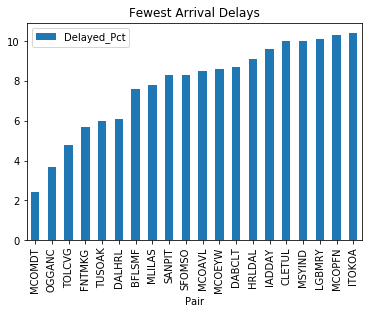

In [34]:
# Plot the first 20 pairs with the fewest arrival delays
Arr_Delay_Pct[:20].plot('Pair', 'Delayed_Pct', kind='bar')
plt.title('Fewest Arrival Delays')
plt.show()

In [60]:
# Calculate the percentage of flights delayed because of Dep Delay
Dep_delays_pct = sqlContext.sql("\
    select a.Origin, a.Dest, a.Num_Total_flights, b.Num_Delayed_Flights, \
    round(b.Num_Delayed_Flights/a.Num_Total_Flights*100,1) as Delayed_Pct \
    from \
    (select Origin, Dest, count(*) as Num_Total_Flights \
    from travel \
    group by Origin, Dest \
    order by Num_Total_Flights desc) a \
    JOIN \
    (select Origin, Dest, count(*) as Num_Delayed_Flights \
    from (select * from travel where DepDelay>0) \
    group by Origin, Dest \
    order by Num_Delayed_Flights desc) b \
    ON a.Origin = b.Origin and a.Dest = b.Dest")

In [62]:
# Sort the data by Delayed percentage, highest first
Dep_delays_pct_worst = Dep_delays_pct.orderBy("Delayed_Pct", \
ascending=False)

In [63]:
# Display data
Dep_delays_pct_worst.show(5)

+------+----+-----------------+-------------------+-----------+
|Origin|Dest|Num_Total_flights|Num_Delayed_Flights|Delayed_Pct|
+------+----+-----------------+-------------------+-----------+
|   AUS| SAT|                3|                  3|      100.0|
|   CDC| SGU|                1|                  1|      100.0|
|   IND| XNA|                1|                  1|      100.0|
|   PIA| MSP|                1|                  1|      100.0|
|   ICT| MCI|                1|                  1|      100.0|
+------+----+-----------------+-------------------+-----------+
only showing top 5 rows



In [64]:
# Change the spark table into a pandas dataframe
Dep_Delay_Pct_W = Dep_delays_pct_worst.toPandas()

In [75]:
# Create a new column that contains both the names of the Origin and Destination
Dep_Delay_Pct_W['Pair'] = Dep_Delay_Pct_W["Origin"].map(str) + \
Dep_Delay_Pct_W["Dest"]

In [78]:
# Filter out the airport pairs with less than 10 total flights
DepDelayPerWorstFiltered = Dep_Delay_Pct_W[Dep_Delay_Pct_W['Num_Total_flights']>10]
# Display filtered results
DepDelayPerWorstFiltered.head(5)

,Origin,Dest,Num_Total_flights,Num_Delayed_Flights,Delayed_Pct,Pair
228,GSO,RDU,11,11,100.0,GSORDU
351,JFK,EGE,14,13,92.9,JFKEGE
352,MKG,GRR,24,22,91.7,MKGGRR
355,EWR,BQN,731,621,85.0,EWRBQN
356,PHL,BTV,187,159,85.0,PHLBTV


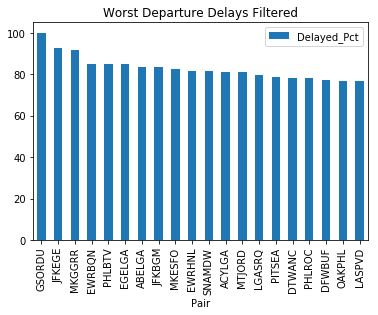

In [79]:
# Plot the first 20 pairs
DepDelayPerWorstFiltered[:20].plot('Pair', 'Delayed_Pct', kind='bar')
plt.title('Worst Departure Delays Filtered')
plt.show()

In [84]:
# Resort by the lowest percentage first
Dep_delays_pct_fewest = \
Dep_delays_pct.orderBy("Delayed_Pct", ascending=True)

In [85]:
# Create a pandas dataframe
Dep_Delay_Pct = Dep_delays_pct_fewest.toPandas()

In [86]:
# Create a new column that combines the names of the Origin and Destination
Dep_Delay_Pct['Pair'] = Dep_Delay_Pct["Origin"].map(str) + \
Dep_Delay_Pct["Dest"]

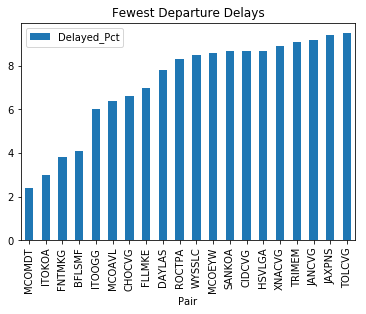

In [87]:
# Plot the pairs with the fewest departure delays
Dep_Delay_Pct[:20].plot('Pair', 'Delayed_Pct', kind='bar')
plt.title('Fewest Departure Delays')
plt.show()

In [88]:
# Calculate the average Arrival delay per month
travel_months = sqlContext.sql("select Month, \
avg(ArrDelay) as Arrival_Delay_Avg \
from travel \
group by Month \
order by Month \
limit 12")
travel_months.show(12)

+-----+------------------+
|Month| Arrival_Delay_Avg|
+-----+------------------+
|    1| 9.667986057033914|
|    2|13.297178217411446|
|    3|10.628322125635558|
|    4| 7.672969790755568|
|    5| 6.518617856652074|
|    6|  14.7405176819636|
|    7|12.070300490176052|
|    8| 9.828288695121863|
|    9|2.3084593506287656|
|   10| 3.642505640109871|
|   11| 3.504175769425841|
|   12|16.433224779052907|
+-----+------------------+



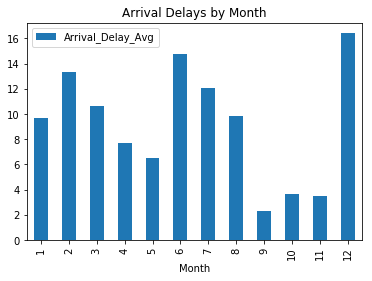

In [91]:
# Change the spark table into a pandas dataframe
Delays_by_month = travel_months.toPandas()
# Plot the average arrival delay by month
Delays_by_month.plot('Month', 'Arrival_Delay_Avg', kind='bar')
plt.title('Arrival Delays by Month')
plt.show()